In [75]:
# !/usr/bin/env python3
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import cross_decomposition
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.font_manager import FontProperties
def getChineseFont():  
    return FontProperties(fname='/System/Library/Fonts/PingFang.ttc',size=15)

In [76]:
df_csv = pd.read_csv('./data/flow_train.csv')
df_csv['date_dt'] = df_csv['date_dt'].apply(lambda x: pd.to_datetime(str(x))) 

In [77]:
df_dist = df_csv.groupby(['district_code'])

In [78]:
df_dist_a = list(df_dist)[0][1]

In [79]:
df_dist_a.head()

,date_dt,city_code,district_code,dwell,flow_in,flow_out
30,2017-06-01,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,92.992996,58.933114,54.144763
149,2017-06-02,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,96.465643,59.727777,53.897340
198,2017-06-03,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,96.523860,60.775684,63.733110
348,2017-06-04,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,91.674380,54.630875,55.119898
450,2017-06-05,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,77.390828,42.114210,41.389408


X shape: (274, 1)
Y shape: (274,)


/Users/higgs/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['STXihei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


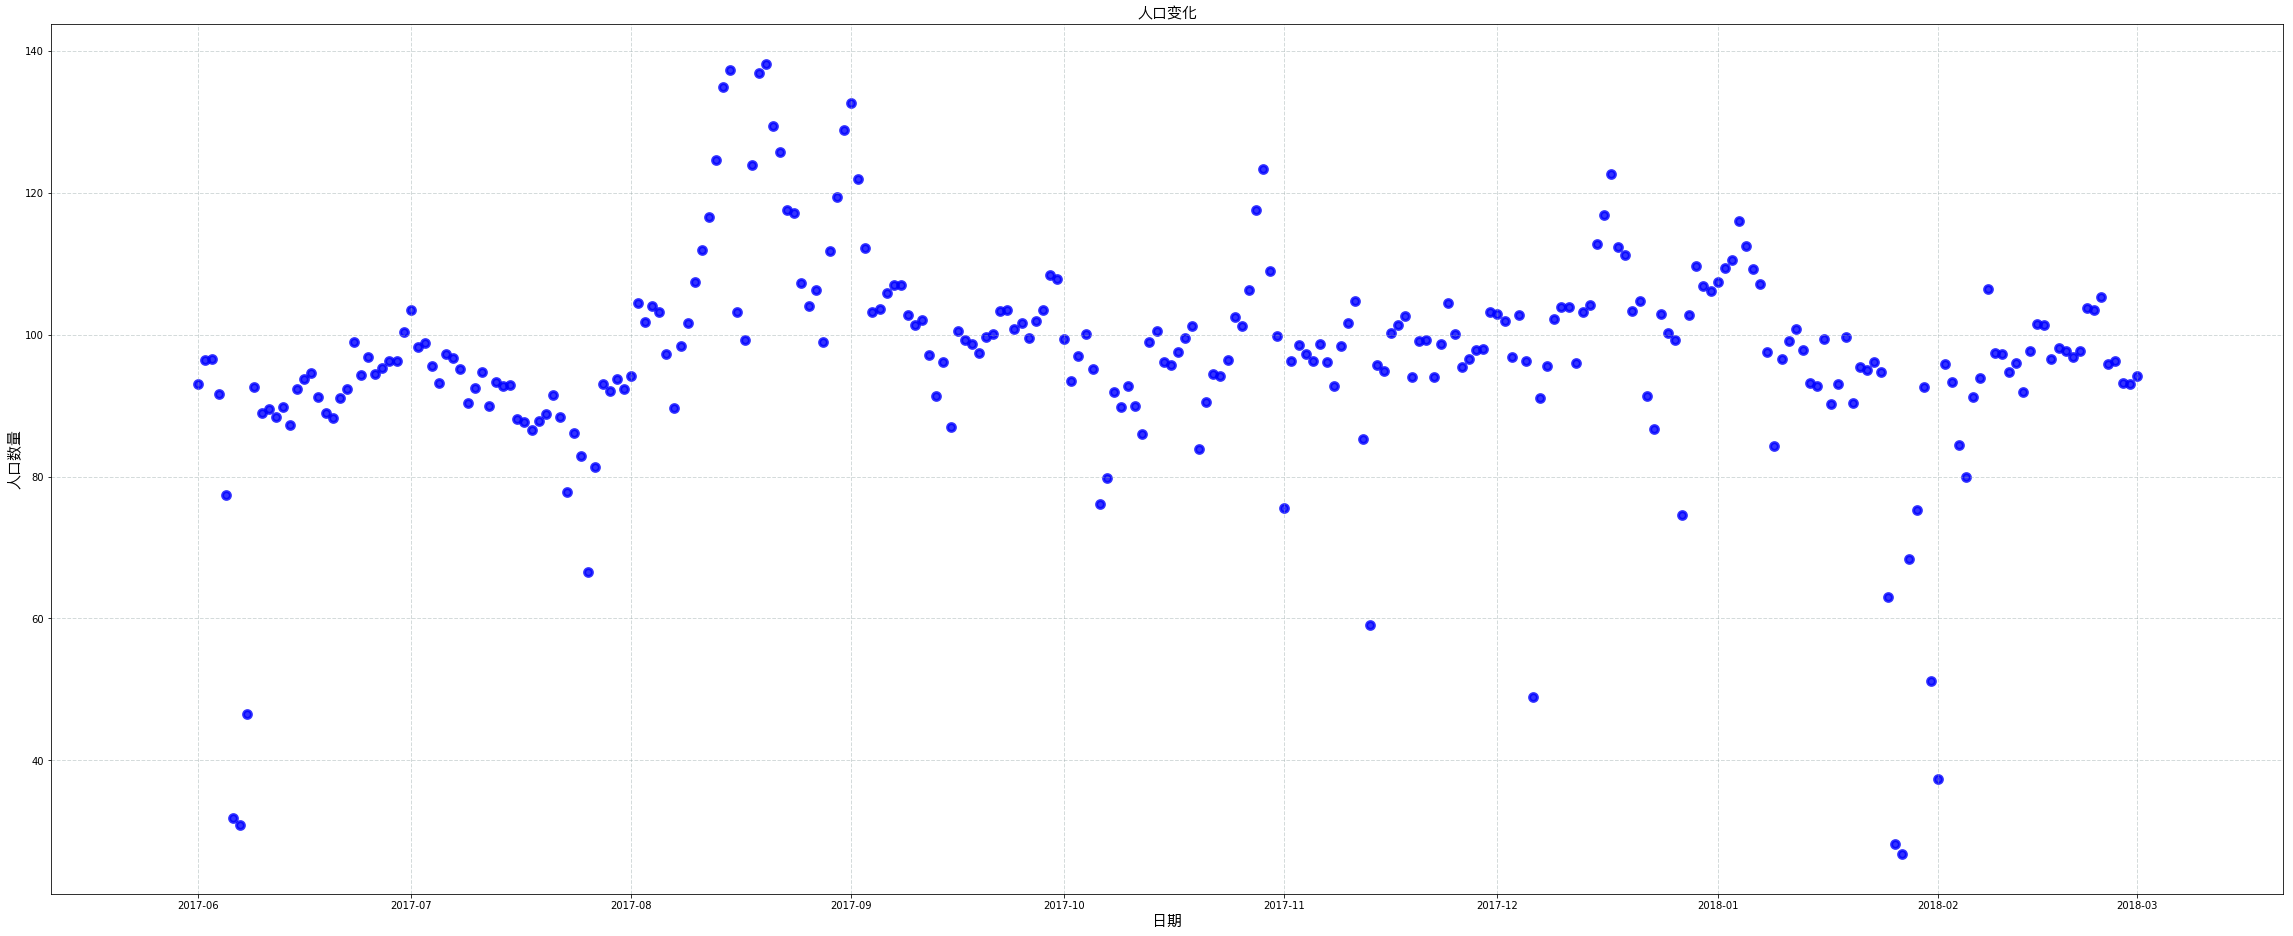

In [93]:
# plt.rc('font', family='STXihei', size=15)
fig,ax = plt.subplots(figsize=(40,16))
X = np.array(df_dist_a[['date_dt']])
Y = np.array(df_dist_a['dwell'])
print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(Y.shape))
plt.scatter(X,Y, 60, color='blue', marker='o', linewidths=3, alpha=0.8)
plt.xlabel('日期',fontproperties=getChineseFont())
plt.ylabel('人口数量', fontproperties=getChineseFont())
plt.title('人口变化', fontproperties=getChineseFont())
plt.grid(color='#95a5a6',linestyle='--', linewidth=1,axis='both',alpha=0.4)

In [81]:
df_dist_a['S_3'] = df_dist_a['dwell'].shift(1).rolling(window=3).mean()
df_dist_a['S_9'] = df_dist_a['dwell'].shift(1).rolling(window=9).mean()

In [82]:
df_dist_a_new = df_dist_a.dropna()

In [83]:
X = df_dist_a_new[['S_3', 'S_9']]
X.head()

,S_3,S_9
976,56.697580,72.998676
985,76.049896,72.541672
1095,90.374200,71.774824
1228,88.940120,70.869549
1352,89.262254,70.666436


In [84]:
Y = df_dist_a_new['dwell']

In [85]:
t=.8   
t = int(t*len(df_dist_a_new))   
# Train dataset   
X_train = X[:t]   
Y_train = Y[:t]    
# Test dataset   
X_test = X[t:]   
Y_test = Y[t:] 

In [86]:
linear = linear_model.LinearRegression().fit(X_train,Y_train)   
print("Gold ETF Price =", round(linear.coef_[0],2),"* 3 Days Moving Average", round(linear.coef_[1],2), "* 9 Days Moving Average +", round(linear.intercept_,2))

Gold ETF Price = 0.57 * 3 Days Moving Average 0.15 * 9 Days Moving Average + 28.42


In [87]:
predicted_price = linear.predict(X_test)

Text(0,0.5,'驻留人口数量')

/Users/higgs/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['STXihei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


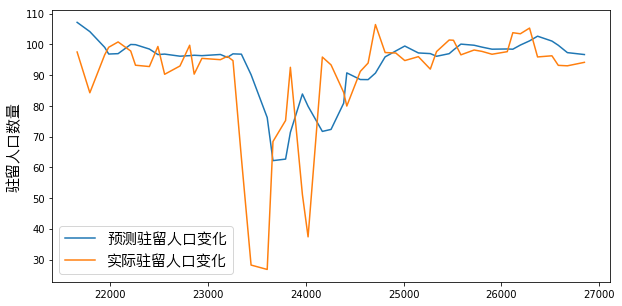

In [91]:
predicted_price = pd.DataFrame(predicted_price,index=Y_test.index,columns = ['price'])   
predicted_price.plot(figsize=(10,5))
Y_test.plot(figsize=(10,5))
plt.legend([u'预测驻留人口变化',u'实际驻留人口变化'], prop=getChineseFont())    
plt.ylabel(u"驻留人口数量", fontproperties=getChineseFont()) 

In [92]:
r2_score = linear.score(X[t:],Y[t:])*100   
float("{0:.2f}".format(r2_score)) 

17.18

对一个区域进行线性拟合的方式，看起来并不可行，需要尝试其它的拟合方式

In [97]:
# 对dwell, flow_in, flow_out同时进行预测
df_dist_a['S_3_d'] = df_dist_a['dwell'].shift(1).rolling(window=3).mean()
df_dist_a['S_6_d'] = df_dist_a['dwell'].shift(1).rolling(window=6).mean()
df_dist_a['S_9_d'] = df_dist_a['dwell'].shift(1).rolling(window=9).mean()
df_dist_a['S_3_i'] = df_dist_a['flow_in'].shift(1).rolling(window=3).mean()
df_dist_a['S_6_i'] = df_dist_a['flow_in'].shift(1).rolling(window=6).mean()
df_dist_a['S_9_i'] = df_dist_a['flow_in'].shift(1).rolling(window=9).mean()
df_dist_a['S_3_o'] = df_dist_a['flow_out'].shift(1).rolling(window=3).mean()
df_dist_a['S_6_o'] = df_dist_a['flow_out'].shift(1).rolling(window=6).mean()
df_dist_a['S_9_o'] = df_dist_a['flow_out'].shift(1).rolling(window=9).mean()

In [99]:
df_dist_a_new = df_dist_a.dropna()
df_dist_a_new.head()

,date_dt,city_code,district_code,dwell,flow_in,flow_out,S_3,S_9,S_3_d,S_6_d,S_9_d,S_3_i,S_6_i,S_9_i,S_3_o,S_6_o,S_9_o
976,2017-06-10,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,88.879962,60.895029,63.290660,56.697580,72.998676,56.697580,61.834264,72.998676,42.077339,41.848838,47.836622,39.972793,40.814515,46.295811
985,2017-06-11,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,89.564013,56.537483,57.562103,76.049896,72.541672,76.049896,61.368527,72.541672,53.562592,42.892863,48.054613,52.206135,42.176308,47.312022
1095,2017-06-12,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,88.376385,55.748642,54.188425,90.374200,71.774824,90.374200,63.397391,71.774824,60.505945,45.296742,47.700136,60.546697,44.871758,47.719218
1228,2017-06-13,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,89.846365,54.939425,52.750464,88.940120,70.869549,88.940120,72.818850,70.869549,57.727051,49.902195,47.141575,58.347063,49.159928,46.658697
1352,2017-06-14,3f7f0ce35d6d0a08377eb2efe2189f4f,01bb949d16b241654d3be95fa224abc8,87.244063,51.187337,50.465445,89.262254,70.666436,89.262254,82.656075,70.666436,55.741850,54.652221,47.175859,54.833664,53.519900,46.395427


In [104]:
X = df_dist_a_new[['S_3_d','S_6_d','S_9_d', 'S_3_i','S_6_i','S_9_i', 'S_3_o','S_6_o','S_9_o']]
Y = df_dist_a_new[['dwell', 'flow_in', 'flow_out']]

In [103]:
Y.head()

,dwell,flow_in,flow_out
976,88.879962,60.895029,63.290660
985,89.564013,56.537483,57.562103
1095,88.376385,55.748642,54.188425
1228,89.846365,54.939425,52.750464
1352,87.244063,51.187337,50.465445


In [105]:
df_dist_a['dwell'].head()

30     92.992996
149    96.465643
198    96.523860
348    91.674380
450    77.390828
Name: dwell, dtype: float64

In [112]:
df_dist_a['dwell'].shift(1).head()

30           NaN
149    92.992996
198    96.465643
348    96.523860
450    91.674380
Name: dwell, dtype: float64

In [113]:
t=.8   
t = int(t*len(df_dist_a_new))   
# Train dataset   
X_train = X[:t]   
Y_train = Y[:t]    
# Test dataset   
X_test = X[t:]   
Y_test = Y[t:] 

In [115]:
linear = linear_model.LinearRegression().fit(X_train,Y_train)   
# print("Gold ETF Price =", round(linear.coef_[0],2),"* 3 Days Moving Average", round(linear.coef_[1],2), "* 9 Days Moving Average +", round(linear.intercept_,2))

In [116]:
predicted_price = linear.predict(X_test)

Text(0,0.5,'驻留人口数量')

/Users/higgs/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['STXihei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


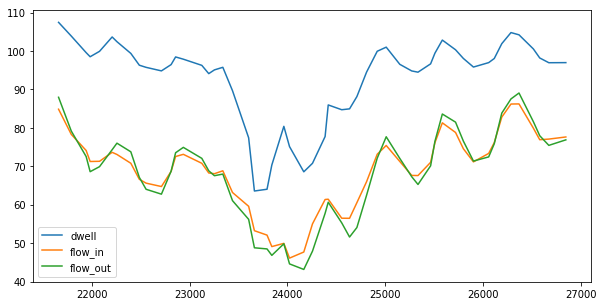

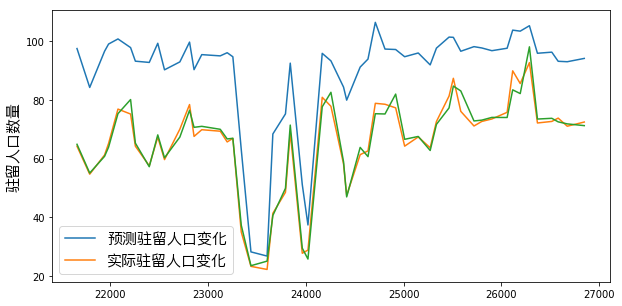

In [121]:
predicted_price = pd.DataFrame(predicted_price,index=Y_test.index,columns = ['dwell', 'flow_in', 'flow_out'])   
predicted_price.plot(figsize=(10,5))
Y_test.plot(figsize=(10,5))
plt.legend([u'预测驻留人口变化',u'实际驻留人口变化'], prop=getChineseFont())    
plt.ylabel(u"驻留人口数量", fontproperties=getChineseFont()) 